In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.6 MB/s eta 0:00:00
✔ Download and installation successful
You 

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [28]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [34]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

Решил воспользоваться читерским методом: "посмотрел на несколько ячеек с кодом вперед". И добавил к спискам позитивных и негативных слов те, которые будут в будущем выявлены с помощью обработки датасета.

In [53]:
positive_words = ('love', 'great', 'best', '7/10', '810', 'refreshing', 'wonderfully', 'funniest',
                  'erotic', 'excellent', 'carrey', 'flawless', 'hooked',
                  'superb', 'perfect', 'subtle', 'highly', 'vengeance',
                  'incredible', 'surprisingly', 'perfectly', 'rare', 'driven',
                  'finest', 'australia', 'touching', 'favorite', 'appreciated',
                  'chavez', 'enjoyable', 'scariest', '9/10', 'underrated',
                  '10/10', 'amazing', 'steals', 'tears', 'whoopi', 'delightful',
                  'flight', 'squirrel', 'units', 'kitty', 'enjoyed',
                  'dealing', 'bound')


negative_words = ('4/10', 'disappointment', '3/10', 'waste', 'poorly', 'worst', 'lacks',
                   '2/10','laughable', 'fails', 'awful', 'avoid', 'boring',
                   'disappointing', 'forgettable', '2/10', 'alright', 'unfunny',
                   'pointless', 'mediocre', 'lame', 'save', 'lousy', 'mst3k',
                   'horrible', 'badly', 'wooden', 'weak', 'baldwin', 'redeeming',
                   'mildly', 'dull', 'worse', 'mess', 'dreadful', 'britney',
                   '1/10', 'annoying', 'unwatchable', 'photo', 'poor', 'generous',
                   'sources', 'terrible', 'bored', 'boredom', 'insult', 'wonder',
                   'uninteresting', 'ridiculous', 'cardboard', 'unfortunately',
                   'miscast', 'ludicrous', 'refer', 'hoping', 'obnoxious', 'basically')


positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))

is_positive = positives_count > negatives_count

correct_count = (is_positive == test_df.is_positive).values.sum()
print(f'correct count:{correct_count}, len(test_df):{len(test_df)}.')

accuracy = correct_count / len(test_df)
print('Test accuracy = {:.2%}'.format(accuracy))

correct count:18931, len(test_df):25000.
Test accuracy = 75.72%


**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [12]:
import re

pattern = re.compile('<br\s?\/>|<br>')

print(train_df['review'].iloc[1])
print('------------------')

print(pattern.subn(' ', train_df['review'].iloc[1])[0])
print('------------------')

This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style.<br /><br />It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations for its contestants to try & overcome. Then it rewards the winner money. If they can spice it up with a little interaction between the characters, even better. While the game format is in slow motion versus Beat The Clock- the real accomplishment of this series is to escape reality. <br /><br />This show has elements of several types of successful past programs. Reality television, hardly, but if your hooked on the contestants, locale or contest, this is your cup of tea. If your not, this entire series is as I say, drivel dripping with gravy. It is another show hiding behind the reality

Применим ее:

In [13]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

### Сделаем дополнительную предобработку текста

In [14]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
mystopwords = stopwords.words("english") + ['the', 'a']

def remove_punktuation(text):
    return re.sub(r'[^\w\s\d]', '', text)

def lower_case(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))

def remove_stopwords(text):
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in mystopwords]
    return ' '.join(text)
    
def normalize(text):
    text = remove_punktuation(text)
    text = lower_case(text)
    text = remove_stopwords(text)
    return text

In [16]:
train_df['review'] = train_df['review'].apply(normalize)
test_df['review'] = test_df['review'].apply(normalize)

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [19]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '000001',
 '00000110',
 '0001',
 '00015',
 '001',
 '0010',
 '002',
 '00383042',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '00s',
 '01',
 '010',
 '01000',
 '010makes',
 '0110',
 '012310',
 '0130',
 '013007',
 '02',
 '029',
 '03',
 '0310',
 '03oct2009',
 '04',
 '041',
 '048',
 '05',
 '050',
 '0510',
 '053105',
 '06',
 '06th',
 '07',
 '079',
 '07kiloton',
 '08',
 '081006',
 '087',
 '089',
 '08th',
 '09',
 '09082009',
 '091505',
 '0f',
 '0ne',
 '0r',
 '0s',
 '0stars',
 '0when',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000000',
 '10000000',
 '1000000000000',
 '1000000000000010000000000000',
 '10002000',
 '1000lb',
 '1000s',
 '1001',
 '100200',
 '100am',
 '100b',
 '100hell',
 '100kin',
 '100m',
 '100min',
 '100minute',
 '100mph',
 '100percent',
 '100plus',
 '100s',
 '100square',
 '100th',
 '100thgrade',
 '100x',
 '100yards',
 '100year',
 '100yearold',
 '100years',
 '101',
 '1010',
 '1010seek',
 '1011',
 '1012',
 '1013',
 '1014',
 '101499',
 '1015',


Попробуем кого-нибудь таки сконвертировать

In [20]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x111517 sparse matrix of type '<class 'numpy.int64'>'
	with 157 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Получилось что надо.

Запустим теперь её на реальных данных.

In [22]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [23]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.99%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [51]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=10)

Посмотрим на конкретные примеры его работы:

In [54]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [55]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [56]:
import numpy as np

preds_vount_vect = model.predict(test_df['review'])

incorrect_pred_index = np.random.choice(np.where(preds_vount_vect != test_df['is_positive'])[0])

eli5.show_prediction(classifier, 
                     test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.32%


In [58]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+7.598,great
+6.185,excellent
+5.128,best
+4.819,perfect
+4.676,wonderful
+4.165,amazing
+4.062,well
+3.835,loved
+3.806,fun
+3.783,today


In [59]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')

eli5.show_prediction(classifier, 
                     test_df['review'].iloc[1], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Positive


In [60]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')

eli5.show_prediction(classifier, 
                     test_df['review'].iloc[6], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Negative


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [61]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.63%


In [62]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.75%


In [63]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.24%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [64]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.65%


In [65]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')

eli5.show_prediction(classifier, 
                     test_df['review'].iloc[1], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
vectorizer = TfidfVectorizer(ngram_range=(3, 7), analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 89.26%


In [67]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')

eli5.show_prediction(classifier, 
                     test_df['review'].iloc[1], 
                     vec=vectorizer, 
                     targets=['positive'], 
                     target_names=['negative', 'positive'])

Positive


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [69]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [70]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B GPE
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faith

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [71]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [72]:
def lemmatized_words(text):
    text_lem = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_lem)

In [73]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [74]:
train_df['lemmatized'] = train_df['review'].apply(lemmatized_words)
test_df['lemmatized'] = test_df['review'].apply(lemmatized_words)

In [75]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.36%


**Задание** Попробуйте вместо лемм классифицировать основы.

In [76]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [77]:
def stemmed_words(text):
    text_stem = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_stem)

In [78]:
train_df['stemmed'] = train_df['review'].apply(stemmed_words)
test_df['stemmed'] = test_df['review'].apply(stemmed_words)

In [79]:
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stemmed'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 83.10%


Score выше при использовании лемм

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [80]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 230 Patch objects>

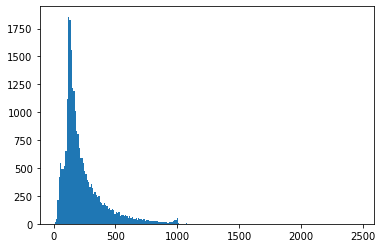

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [82]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 27299


**Задание** Сконвертируйте данные

In [83]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

<ipython-input-83-27b1b5540537>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
<ipython-input-83-27b1b5540537>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [84]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [85]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [86]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1747136   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,747,907
Trainable params: 1,747,907
Non-trainable params: 0
______________________________________________

In [87]:
model.fit(X_train, 
          train_df.is_positive, 
          batch_size=128, 
          epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 5s 12ms/step - loss: 0.6252 - accuracy: 0.7276 - val_loss: 0.4371 - val_accuracy: 0.8314
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.3283 - accuracy: 0.8676 - val_loss: 0.3097 - val_accuracy: 0.8660
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2062 - accuracy: 0.9202 - val_loss: 0.2928 - val_accuracy: 0.8769
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1253 - accuracy: 0.9592 - val_loss: 0.3051 - val_accuracy: 0.8774
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0695 - accuracy: 0.9815 - val_loss: 0.3351 - val_accuracy: 0.8730
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0340 - accuracy: 0.9934 - val_loss: 0.3776 - val_accuracy: 0.8705
Epoch 7/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0155 - accuracy: 0.9981 - val_loss: 0.4096 - val_accuracy: 0.8682
Epo

**Задание** Подсчитайте качество модели на тесте

In [88]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 2s 3ms/step - loss: 0.4875 - accuracy: 0.8665


[0.4875241816043854, 0.8665199875831604]

In [89]:
X_train = convert(train_df.lemmatized, word2idx, 1000)
X_test = convert(test_df.lemmatized, word2idx, 1000)

<ipython-input-83-27b1b5540537>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
<ipython-input-83-27b1b5540537>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

In [90]:
model.fit(X_train, 
          train_df.is_positive, 
          batch_size=128,
          epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 2s 11ms/step - loss: 0.2028 - accuracy: 0.9238 - val_loss: 0.3898 - val_accuracy: 0.8613
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0800 - accuracy: 0.9742 - val_loss: 0.4214 - val_accuracy: 0.8594
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0423 - accuracy: 0.9902 - val_loss: 0.4650 - val_accuracy: 0.8563
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0216 - accuracy: 0.9971 - val_loss: 0.5132 - val_accuracy: 0.8548
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0114 - accuracy: 0.9993 - val_loss: 0.5474 - val_accuracy: 0.8542
Epoch 6/10
196/196 [==============================] - 3s 14ms/step - loss: 0.0066 - accuracy: 0.9997 - val_loss: 0.5805 - val_accuracy: 0.8531
Epoch 7/10
196/196 [==============================] - 3s 14ms/step - loss: 0.0045 - accuracy: 0.9998 - val_loss: 0.6080 - val_accuracy: 0.8534
Ep

In [91]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 2s 3ms/step - loss: 0.6746 - accuracy: 0.8517


[0.6745741963386536, 0.8517199754714966]

In [92]:
X_train = convert(train_df.stemmed, word2idx, 1000)
X_test = convert(test_df.stemmed, word2idx, 1000)

<ipython-input-83-27b1b5540537>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
<ipython-input-83-27b1b5540537>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

In [93]:
model.fit(X_train, 
          train_df.is_positive, 
          batch_size=128, 
          epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 2s 11ms/step - loss: 0.3668 - accuracy: 0.8684 - val_loss: 0.4008 - val_accuracy: 0.8281
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.1799 - accuracy: 0.9329 - val_loss: 0.4615 - val_accuracy: 0.8220
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1256 - accuracy: 0.9564 - val_loss: 0.5152 - val_accuracy: 0.8164
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0857 - accuracy: 0.9751 - val_loss: 0.5714 - val_accuracy: 0.8160
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0582 - accuracy: 0.9852 - val_loss: 0.6429 - val_accuracy: 0.8104
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0382 - accuracy: 0.9920 - val_loss: 0.6988 - val_accuracy: 0.8126
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0243 - accuracy: 0.9962 - val_loss: 0.7806 - val_accuracy: 0.8084


In [94]:
model.evaluate(X_test, test_df.is_positive)

782/782 [==============================] - 3s 4ms/step - loss: 0.9718 - accuracy: 0.8058


[0.9717622399330139, 0.8058000206947327]

Лучший score у сети на лемматизированных текстах